In [114]:
# group comparisons
import pandas as pd
import ast
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [115]:
ideology_labeled_moderation = pd.read_csv('./results/ideology_labeled_moderated_stable.csv')#russian_english_backtranslation_ideology_labeled_moderated_stable.csv')#ideology_subgroup_latest_March28th.csv')
ideology_labeled_moderation_german_bt = pd.read_csv('./results/german_english_backtranslation_helsinki_ideology_labeled_moderated_stable.csv')
ideology_labeled_moderation_french_bt = pd.read_csv('./results/french_english_backtranslation_helsinki_ideology_labeled_moderated_stable.csv')
ideology_labeled_moderation_hungarian_bt = pd.read_csv('./results/hungarian_english_backtranslation_helsinki_ideology_labeled_moderated_stable.csv')

In [116]:
# ideology_subgroup_moderation[ideology_subgroup_moderation['flagged_run'] == False].to_csv('synonym_augmented_labeled_ideology_flagged_to_unflagged.csv')

In [117]:
def flagged_stats(groups, flagged=True):
    results = []
    for group in groups:
        group_flagged = len(group[group['flagged_run'] == flagged])  
        results += [round(group_flagged*100/len(group), 2)]
    return results

In [118]:
def get_moderation(df, column, categories):
    moderations = []
    for category in categories:
        moderations += [df[df[column] == category]]
    
    print(f"""The stable moderation model flagged percentage {tuple(categories)} is: 
            {flagged_stats(moderations)}""")
    return moderations

In [119]:
original_moderations = get_moderation(ideology_labeled_moderation, column='label', categories=['left', 'balanced', 'right']) # original annotated data
gerrmanbt_moderations = get_moderation(ideology_labeled_moderation_german_bt, column='label', categories=['left', 'balanced', 'right']) # german backtranslated
frenchbt_moderations = get_moderation(ideology_labeled_moderation_french_bt, column='label', categories=['left', 'balanced', 'right']) # french backtranslated
hungarianbt_moderations = get_moderation(ideology_labeled_moderation_hungarian_bt, column='label', categories=['left', 'balanced', 'right']) # hungarian backtranslated

The stable moderation model flagged percentage ('left', 'balanced', 'right') is: 
            [23.58, 13.33, 31.9]
The stable moderation model flagged percentage ('left', 'balanced', 'right') is: 
            [80.67, 74.65, 85.89]
The stable moderation model flagged percentage ('left', 'balanced', 'right') is: 
            [74.67, 66.2, 73.01]
The stable moderation model flagged percentage ('left', 'balanced', 'right') is: 
            [70.67, 60.56, 70.55]


In [120]:
# Is the flagging between groups caused by the same classes
chars_to_remove = ['-', '_', '/']
def compute_classwise(moderation_df, flagged=None):
    classwise_scores = defaultdict(list)
    for idx, row in moderation_df.iterrows():
        score = row['scores']
        score = ast.literal_eval(score)
        for k,v in score.items():
            if flagged == True:
                if row['flagged_run'] == True:
                    classwise_scores[k] += [v]
            elif flagged == False:
                if row['flagged_run'] == False:
                    classwise_scores[k] += [v]
            else:
                classwise_scores[k] += [v]

    new_classwise_scores = {}
    for k,v in classwise_scores.items():
        if '/' in k and k.replace('/', '_') in classwise_scores.keys():
            assert round(np.mean(classwise_scores[k.replace('/', '_')]),2) == round(np.mean(classwise_scores[k]),2)
        elif '-' in k and k.replace('-', '_') in classwise_scores.keys():
            assert round(np.mean(classwise_scores[k.replace('-', '_')]),2) == round(np.mean(classwise_scores[k]),2)
        
        new_classwise_scores[k.translate({ord(x): '_' for x in chars_to_remove})] = v
    classwise_scores = new_classwise_scores
    classwise_scores = {k:np.mean(v) for k,v in classwise_scores.items()}
    return classwise_scores

In [121]:
# get class-wise difference between any two categories
def get_classwise_difference(dfs, categories, flagged=True):
    assert len(dfs) == len(categories)

    classwise_stats = []
    for df in dfs:
        classwise_stats += [compute_classwise(df, flagged=flagged)]
    
    # define a map to store categorical comparisons
    probability_comparison = {}
    # compute classwise difference between any two categories
    for i in range(0, len(dfs)):
        cat_a = categories[i]
        prob_a = classwise_stats[i]
        for j in range(i+1, len(dfs)):
            cat_b = categories[j]
            if f'{cat_b}-{cat_a}' not in probability_comparison.keys():
                prob_b = classwise_stats[j]
                probability_comparison[f'{cat_a}-{cat_b}'] = {k:abs(prob_b[k]-v)*100/(prob_b[k] + v) for k,v in prob_a.items()}

    return probability_comparison

In [122]:
categories=['left','balanced','right']
original_moderations_cw = get_classwise_difference(original_moderations, categories=categories, flagged=True)
germanbt_moderations_cw = get_classwise_difference(gerrmanbt_moderations, categories=categories, flagged=True)
frenchbt_moderations_cw = get_classwise_difference(frenchbt_moderations, categories=categories, flagged=True)
hungarianbt_moderations_cw = get_classwise_difference(hungarianbt_moderations, categories=categories, flagged=True)

In [123]:
def create_bar_plots(*dicts, names):
    common_keys = set.intersection(*[set(d.keys()) for d in dicts])
    
    for key in common_keys:
        values = [d[key] for d in dicts]

        # Plotting
        fig, ax = plt.subplots()
        bar_width = 0.2
        index = np.arange(len(values[0].keys()))

        for i, v in enumerate(values):
            ax.bar(index + i * bar_width, v.values(), bar_width, label=names[i])

        ax.set_xlabel('Classes')
        ax.set_ylabel('Difference (%)')
        ax.set_title(f'Classwise Probability Difference: {key}')
        ax.set_xticks(index + bar_width * (len(dicts) - 1) / 2)
        ax.set_xticklabels(values[0].keys())
        ax.legend()
        plt.xticks(rotation='vertical')
        plt.savefig(f'./results/{key}_classwise_diff.png')
        # plt.show()

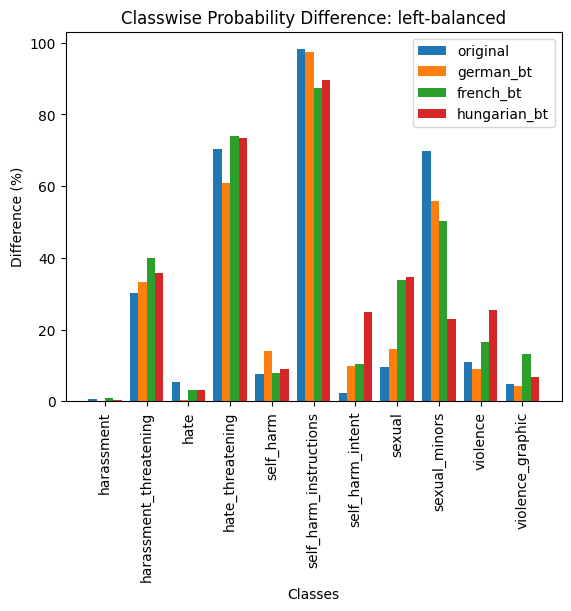

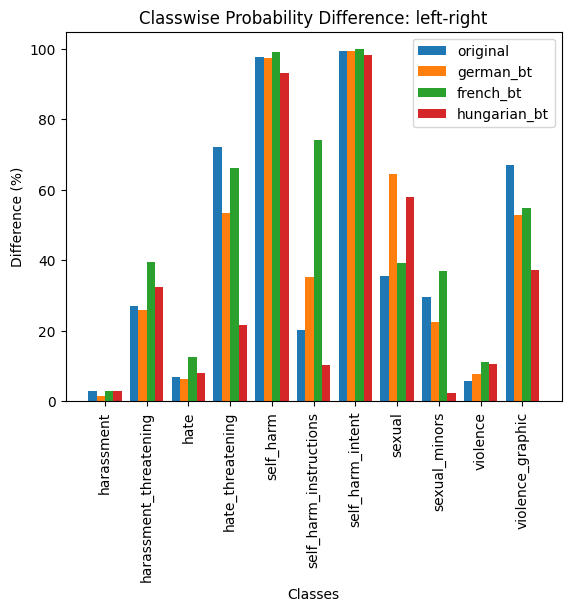

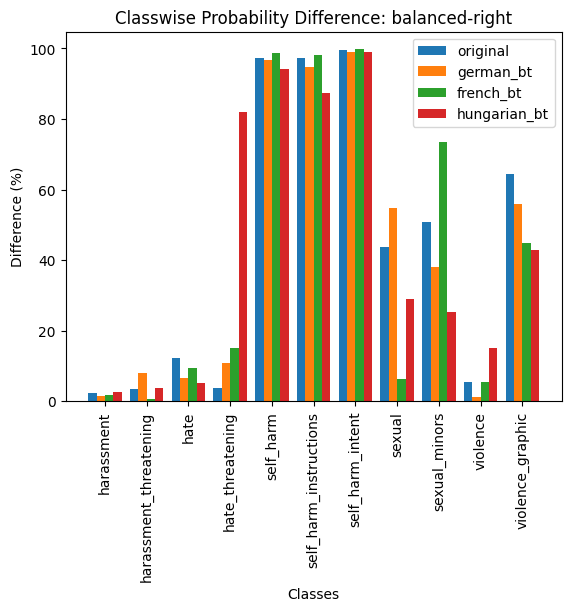

In [124]:
names = ['original', 'german_bt', 'french_bt', 'hungarian_bt']
create_bar_plots(original_moderations_cw, germanbt_moderations_cw, frenchbt_moderations_cw, hungarianbt_moderations_cw, names=names)